# Loading/Cleaning Datasets

In [167]:
# Our needed packages
import pandas as pd
import time
from sodapy import Socrata
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from geopy.distance import geodesic
from pandas.tseries.offsets import *
import seaborn as sns
import numpy as np
import datetime

## School Dataset

Some links: https://data.cityofnewyork.us/Education/2006-2009-Historical-Daily-Attendance-By-School/xwxx-rnki

https://data.cityofnewyork.us/Education/2010-2016-School-Safety-Report/qybk-bjjc

In [168]:
# create a client object using the Socrata library
client = Socrata("data.cityofnewyork.us", None)

'''
Takes long time to run
# Define a list of the URLs for the attendance datasets
attendance_urls = [
    "xwxx-rnki",
    "wpqj-3buw",
    "pffu-gbfi",
    "46g3-savk",
    "xc44-2jrh"
]

# Create a list comprehension to read each CSV file into a data frame and store it in a list
dfs = [pd.DataFrame.from_records(client.get_all(url)) for url in attendance_urls]

# Concatenate all the data frames in the dfs list into a single data frame
attendance_df = pd.concat(dfs)

attendance_df.to_csv('Merged_Attendance.csv')
'''

# retrieve all data from the specified dataset
results = client.get_all("qybk-bjjc")

# create a pandas dataframe from the retrieved data, specifying the column names
schools_df = pd.DataFrame.from_records(results,columns=['longitude','latitude','dbn'])

# drop any duplicate rows from the dataframe
schools_df.drop_duplicates(inplace=True)

# convert the latitude and longitude columns to floats
schools_df['latitude']=schools_df['latitude'].astype(float)
schools_df['longitude']=schools_df['longitude'].astype(float)

# read in a csv file containing attendance data, specifying the data types of the columns and setting the first column as the index
attendance_df=pd.read_csv('Merged_Attendance.csv', dtype={'school': str,'date': str},index_col=0)

# drop any duplicate rows from the dataframe
attendance_df.drop_duplicates(inplace=True)

# drop duplicate rows
attendance_df.drop_duplicates(inplace=True)

num_nan = attendance_df['school'].isnull().sum()
print(f"There are {num_nan} NaN values in column 'school'.")

# drop rows with NaN values in column 'school'
attendance_df.dropna(subset=['school'],inplace=True)


school_df = pd.merge(attendance_df, schools_df, left_on='school', right_on='dbn', how='left')
del school_df['dbn']

# Print the number of rows not found
print(f"{school_df['latitude'].isnull().sum()} rows were not found in the schools dataset.")
school_df.dropna(subset=['latitude'],inplace=True)

# Prints the first columns and few rows of the dataframe
print(len(school_df))
school_df.head()



There are 727707 NaN values in column 'school'.
84491 rows were not found in the schools dataset.
2992352


,school,date,schoolyear,enrolled,present,absent,released,longitude,latitude
0,01M015,20060905,20062007,252.0,226.0,26.0,0.0,-73.979022,40.721807
1,01M015,20060906,20062007,248.0,227.0,21.0,0.0,-73.979022,40.721807
2,01M015,20060907,20062007,245.0,228.0,17.0,0.0,-73.979022,40.721807
3,01M015,20060908,20062007,246.0,226.0,20.0,0.0,-73.979022,40.721807
4,01M015,20060911,20062007,248.0,223.0,25.0,0.0,-73.979022,40.721807


## Bike Dataset

Links: https://data.cityofnewyork.us/Transportation/Bicycle-Counts/uczf-rk3c

https://data.cityofnewyork.us/Transportation/Bicycle-Counters/smn3-rzf9

In [169]:
# create a client object using the Socrata library
client = Socrata("data.cityofnewyork.us", None)

'''
Takes long time to run 
results = client.get_all("uczf-rk3c")
count_df = pd.DataFrame.from_records(results)
count_df.to_csv('Bike_count.csv')
'''
count_df=pd.read_csv('Bike_count.csv',dtype={'id':str},index_col=0)

# retrieve all data from the specified dataset
results = client.get_all("smn3-rzf9")
count_location = pd.DataFrame.from_records(results)
count_location = count_location[['latitude','longitude','id']]
count_location['latitude']=count_location['latitude'].astype(float)
count_location['longitude']=count_location['longitude'].astype(float)


# Merge the two datasets on the "id" column
bike_df = pd.merge(count_df, count_location, on='id')

# Count the number of rows in the first dataset that are not in the merged dataset
non_matching_rows = bike_df[~bike_df['id'].isin(count_df['id'])].shape[0]

# Print the number of non-matching rows
print(f"Number of non-matching rows: {non_matching_rows}")

# Prints the first columns and few rows of the dataframe
bike_df.head()

Number of non-matching rows: 0


,countid,id,date,counts,status,latitude,longitude
0,10014848,100009425,2022-06-24T00:00:00.000,15,0,40.671288,-73.971382
1,10014849,100009425,2022-06-24T00:15:00.000,12,0,40.671288,-73.971382
2,10014850,100009425,2022-06-24T00:30:00.000,14,0,40.671288,-73.971382
3,10014851,100009425,2022-06-24T00:45:00.000,5,0,40.671288,-73.971382
4,10014852,100009425,2022-06-24T01:00:00.000,10,0,40.671288,-73.971382


## Borough Population

Link: https://data.cityofnewyork.us/City-Government/New-York-City-Population-by-Borough-1950-2040/xywu-7bv9

In [170]:
start_time = time.time()

# create a client object using the Socrata library
client = Socrata("data.cityofnewyork.us", None)

# retrieve all data from the specified dataset
results = client.get_all("xywu-7bv9")
bor_population = pd.DataFrame.from_records(results)

print(f"Population data frame loaded in {time.time() - start_time:.2f} seconds.")

#bor_population = pd.read_csv('https://data.cityofnewyork.us/resource/xywu-7bv9.csv')
bor_population['borough'] = bor_population['borough'].str.upper()

# Prints the first columns and few rows of the dataframe
print(bor_population.columns)
bor_population.head()

Population data frame loaded in 0.78 seconds.
Index(['age_group', 'borough', '_1950', '_1950_boro_share_of_nyc_total',
       '_1960', '_1960_boro_share_of_nyc_total', '_1970',
       '_1970_boro_share_of_nyc_total', '_1980',
       '_1980_boro_share_of_nyc_total', '_1990',
       '_1990_boro_share_of_nyc_total', '_2000',
       '_2000_boro_share_of_nyc_total', '_2010',
       '_2010_boro_share_of_nyc_total', '_2020',
       '_2020_boro_share_of_nyc_total', '_2030',
       '_2030_boro_share_of_nyc_total', '_2040',
       '_2040_boro_share_of_nyc_total'],
      dtype='object')


,age_group,borough,_1950,_1950_boro_share_of_nyc_total,_1960,_1960_boro_share_of_nyc_total,_1970,_1970_boro_share_of_nyc_total,_1980,_1980_boro_share_of_nyc_total,...,_2000,_2000_boro_share_of_nyc_total,_2010,_2010_boro_share_of_nyc_total,_2020,_2020_boro_share_of_nyc_total,_2030,_2030_boro_share_of_nyc_total,_2040,_2040_boro_share_of_nyc_total
0,Total Population,NYC TOTAL,7891957,100.00,7781984,100.00,7894862,100.00,7071639,100.00,...,8008278,100.00,8242624,100.00,8550971,100.00,8821027,100.00,9025145,100.00
1,Total Population,BRONX,1451277,18.39,1424815,18.31,1471701,18.64,1168972,16.53,...,1332650,16.64,1385108,16.80,1446788,16.92,1518998,17.22,1579245,17.50
2,Total Population,BROOKLYN,2738175,34.70,2627319,33.76,2602012,32.96,2230936,31.55,...,2465326,30.78,2552911,30.97,2648452,30.97,2754009,31.22,2840525,31.47
3,Total Population,MANHATTAN,1960101,24.84,1698281,21.82,1539233,19.50,1428285,20.20,...,1537195,19.20,1585873,19.24,1638281,19.16,1676720,19.01,1691617,18.74
4,Total Population,QUEENS,1550849,19.65,1809578,23.25,1986473,25.16,1891325,26.75,...,2229379,27.84,2250002,27.30,2330295,27.25,2373551,26.91,2412649,26.73


## Construction-related projects applications

Link: https://data.cityofnewyork.us/Housing-Development/DOB-Job-Application-Filings/ic3t-wcy2

In [171]:
'''
Takes long time
results = client.get_all("ic3t-wcy2")
construction_df = pd.DataFrame.from_records(results)
construction_df=construction_df[['job__','borough','gis_latitude', 'gis_longitude','total_est__fee', 'proposed_no_of_stories', 'job_type','proposed_occupancy']]
construction_df.to_csv('Construction_applications_v2.csv')
'''
# Loading csv
construction_df=pd.read_csv('Construction_applications_v2.csv')

# Prints the first columns and few rows of the dataframe
print(construction_df.columns)
construction_df.head()

Index(['Unnamed: 0', 'job__', 'borough', 'gis_latitude', 'gis_longitude',
       'total_est__fee', 'proposed_no_of_stories', 'job_type',
       'proposed_occupancy'],
      dtype='object')


,Unnamed: 0,job__,borough,gis_latitude,gis_longitude,total_est__fee,proposed_no_of_stories,job_type,proposed_occupancy
0,0,301793156,BROOKLYN,40.685185,-73.912220,$200.00,3,A3,NaN
1,1,301776077,BROOKLYN,40.717318,-73.955431,$150.30,5,A2,NaN
2,2,301776291,BROOKLYN,40.638728,-74.001250,$682.30,3,A1,J-0
3,3,302163557,BROOKLYN,40.687317,-73.979159,$9866.44,12,A1,J-2
4,4,301773631,BROOKLYN,40.659043,-73.960526,$603.50,3,A1,COM


## Shooting dataset

Link: https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Historic-/833y-fsy8

In [172]:
#Loading the shooting dataset
start_time = time.time()

# retrieve all data from the specified dataset
results = client.get_all("833y-fsy8")

print(f"Shooting data frame loaded in {time.time() - start_time:.2f} seconds.")


# Convert to pandas DataFrame
shooting_df = pd.DataFrame.from_records(results)

# Convert to datetime for later merging
shooting_df['occur_date']=pd.to_datetime(shooting_df['occur_date'])
shooting_df['occur_time']=pd.to_datetime(shooting_df['occur_time'])


print(shooting_df.columns)
shooting_df.head()

Shooting data frame loaded in 0.00 seconds.
Index(['incident_key', 'occur_date', 'occur_time', 'boro', 'precinct',
       'jurisdiction_code', 'statistical_murder_flag', 'vic_age_group',
       'vic_sex', 'vic_race', 'x_coord_cd', 'y_coord_cd', 'latitude',
       'longitude', 'geocoded_column', ':@computed_region_yeji_bk3q',
       ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih',
       ':@computed_region_efsh_h5xi', ':@computed_region_f5dn_yrer',
       'perp_age_group', 'perp_sex', 'perp_race', 'location_desc',
       'loc_of_occur_desc', 'loc_classfctn_desc'],
      dtype='object')


,incident_key,occur_date,occur_time,boro,precinct,jurisdiction_code,statistical_murder_flag,vic_age_group,vic_sex,vic_race,...,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,perp_age_group,perp_sex,perp_race,location_desc,loc_of_occur_desc,loc_classfctn_desc
0,228798151,2021-05-27,2023-05-11 21:30:00,QUEENS,105,0,False,18-24,M,BLACK,...,47,63,24018,63,NaN,NaN,NaN,NaN,NaN,NaN
1,137471050,2014-06-27,2023-05-11 17:40:00,BRONX,40,0,False,18-24,M,BLACK,...,35,23,10932,49,NaN,NaN,NaN,NaN,NaN,NaN
2,147998800,2015-11-21,2023-05-11 03:56:00,QUEENS,108,0,True,25-44,M,WHITE,...,33,66,14787,53,NaN,NaN,NaN,NaN,NaN,NaN
3,146837977,2015-10-09,2023-05-11 18:30:00,BRONX,44,0,False,<18,M,WHITE HISPANIC,...,42,27,10930,50,NaN,NaN,NaN,NaN,NaN,NaN
4,58921844,2009-02-19,2023-05-11 22:58:00,BRONX,47,0,True,45-64,M,BLACK,...,2,30,11275,29,25-44,M,BLACK,NaN,NaN,NaN


# Further Cleaning + Merging/Examples of Merging + Some analysis

## For schools

In [173]:
# Create a copy of the original df
shootings_df=shooting_df.copy()

In [174]:
school_df.head()

,school,date,schoolyear,enrolled,present,absent,released,longitude,latitude
0,01M015,20060905,20062007,252.0,226.0,26.0,0.0,-73.979022,40.721807
1,01M015,20060906,20062007,248.0,227.0,21.0,0.0,-73.979022,40.721807
2,01M015,20060907,20062007,245.0,228.0,17.0,0.0,-73.979022,40.721807
3,01M015,20060908,20062007,246.0,226.0,20.0,0.0,-73.979022,40.721807
4,01M015,20060911,20062007,248.0,223.0,25.0,0.0,-73.979022,40.721807


In [175]:
# record the start time for benchmarking purposes
start_time = time.time()

# convert the date column to a datetime format, then extract the year and month and calculate the number of months since September 2005 (the start of the NYC school year)
school_df['date'] = school_df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d').strftime('%Y-%m-%d'))
school_df['date'] = pd.to_datetime(school_df['date'])
school_df['month'] = (school_df['date'].dt.year-2006)*12+school_df['date'].dt.month

# calculate attendance rate as the number of students present divided by the number enrolled
school_df['attendance'] = (school_df['present']) / school_df['enrolled']

# calculate the total time taken to run this code block and print it out
print(f"data chunk loaded in {time.time() - start_time:.2f} seconds.")

data chunk loaded in 11.12 seconds.


In [176]:
# group the school dataframe by date and calculate the mean and standard deviation of attendance for each date
grouped_df = school_df.groupby(['date'])['attendance'].agg(['mean', 'std']).reset_index()

# merge the grouped data back into the original school dataframe based on the date column
school_df = pd.merge(school_df, grouped_df, on=['date'])

# calculate the z-score for attendance for each date, based on the mean and standard deviation for that date
school_df['z_score'] = (school_df['attendance'] - school_df['mean']) / school_df['std']

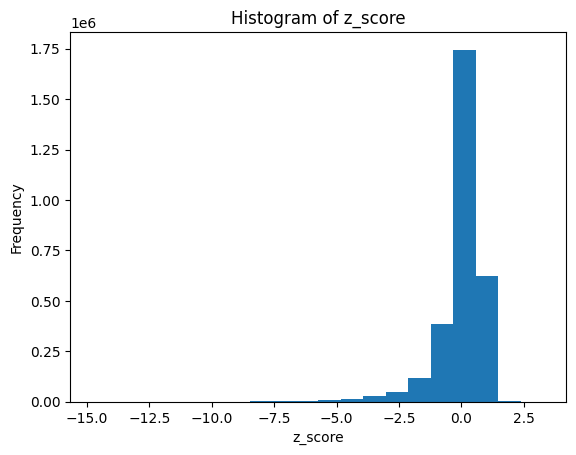

In [177]:
# extract the z-scores from the school dataframe and store them in a separate variable
z_scores = school_df['z_score']

# create a histogram of the z-scores using Matplotlib, with 20 bins
plt.hist(z_scores, bins=20)

# label the x-axis as 'z_score'
plt.xlabel('z_score')

# label the y-axis as 'Frequency'
plt.ylabel('Frequency')

# set the title of the plot as 'Histogram of z_score'
plt.title('Histogram of z_score')

# display the plot
plt.show()

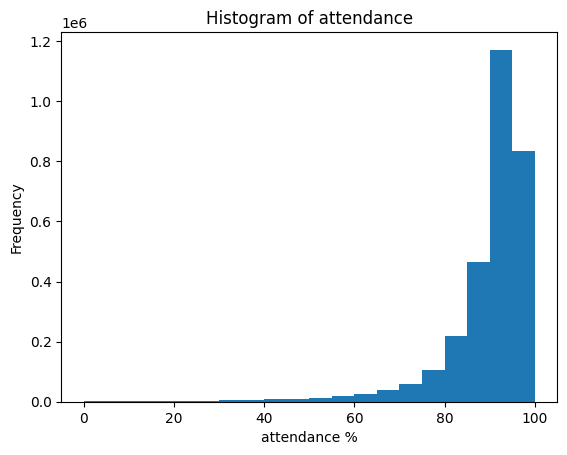

In [178]:
# extract the attendance values from the school dataframe, multiply them by 100 to get percentages, and store them in a separate variable
attendances = school_df['attendance']*100

# create a histogram of the attendance percentages using Matplotlib, with 20 bins
plt.hist(attendances, bins=20)

# label the x-axis as 'attendance %'
plt.xlabel('attendance %')

# label the y-axis as 'Frequency'
plt.ylabel('Frequency')

# set the title of the plot as 'Histogram of attendance'
plt.title('Histogram of attendance')

# display the plot
plt.show()

In [179]:
# Create a copy of the original df
shootings_df=shooting_df.copy()

In [180]:
shootings_df.location_desc.value_counts()

MULTI DWELL - PUBLIC HOUS    4832
MULTI DWELL - APT BUILD      2835
(null)                        977
PVT HOUSE                     951
GROCERY/BODEGA                694
BAR/NIGHT CLUB                628
COMMERCIAL BLDG               292
RESTAURANT/DINER              204
NONE                          175
BEAUTY/NAIL SALON             112
FAST FOOD                     104
SOCIAL CLUB/POLICY LOCATI      72
GAS STATION                    71
HOSPITAL                       65
LIQUOR STORE                   41
SMALL MERCHANT                 37
STORE UNCLASSIFIED             36
HOTEL/MOTEL                    35
DRY CLEANER/LAUNDRY            31
SUPERMARKET                    21
DRUG STORE                     14
CLOTHING BOUTIQUE              14
JEWELRY STORE                  12
TELECOMM. STORE                11
VARIETY STORE                  11
SHOE STORE                     10
DEPT STORE                      9
FACTORY/WAREHOUSE               8
VIDEO STORE                     8
CANDY STORE   

In [181]:
public_places=['GROCERY/BODEGA', 'BAR/NIGHT CLUB', 'COMMERCIAL BLDG',
       'RESTAURANT/DINER', 'BEAUTY/NAIL SALON', 'FAST FOOD',
       'SOCIAL CLUB/POLICY LOCATI', 'GAS STATION', 'HOSPITAL', 'LIQUOR STORE',
       'SMALL MERCHANT', 'STORE UNCLASSIFIED', 'HOTEL/MOTEL',
       'DRY CLEANER/LAUNDRY', 'SUPERMARKET', 'DRUG STORE', 'CLOTHING BOUTIQUE',
       'JEWELRY STORE', 'TELECOMM. STORE', 'VARIETY STORE', 'SHOE STORE',
       'DEPT STORE', 'FACTORY/WAREHOUSE', 'VIDEO STORE', 'CANDY STORE',
       'CHAIN STORE', 'GYM/FITNESS FACILITY', 'BANK', 'DOCTOR/DENTIST', 'ATM',
       'SCHOOL', 'LOAN COMPANY', 'PHOTO/COPY STORE', 'CHECK CASH',
       'STORAGE FACILITY']
shootings_df['shooting_in_public']=(shootings_df['location_desc'].isin(public_places))

In [182]:
shootings_df=shootings_df[['incident_key','latitude','longitude','occur_date','shooting_in_public']]
shootings_df['latitude']=shootings_df['latitude'].astype(float)
shootings_df['longitude']=shootings_df['longitude'].astype(float)

In [183]:
school_df_aux=school_df.drop_duplicates(subset='school')
shootings_df.dropna(subset=['latitude','longitude'],inplace=True)
school_df_aux.dropna(subset=['latitude','longitude'],inplace=True)
# create pairwise distance matrix
distances = cdist(shootings_df[['latitude', 'longitude']], school_df_aux[['latitude', 'longitude']])

# find index of minimum distance for each row in df1
min_idx = np.argmin(distances, axis=1)
min_dist = np.min(distances, axis=1)

min_dist_km = [geodesic((shootings_df.iloc[i]['latitude'], shootings_df.iloc[i]['longitude']), (school_df_aux.iloc[min_idx[i]]['latitude'], school_df_aux.iloc[min_idx[i]]['longitude'])).km for i in range(len(shootings_df))]

# add nearest id to df1
shootings_df['nearest_id'] = school_df_aux.iloc[min_idx]['school'].values
shootings_df['distance']=min_dist_km

shootings_df = shootings_df.merge(school_df[['school', 'date', 'z_score','attendance','released']], left_on=['nearest_id', 'occur_date'], right_on=['school', 'date']).drop(['school','date'], axis=1)

from datetime import timedelta
shootings_df['occur_date_plus1']=shootings_df['occur_date']+ BDay(1)
shootings_df = shootings_df.merge(school_df[['school', 'date','z_score','attendance','released']], left_on=['nearest_id', 'occur_date_plus1'], right_on=['school', 'date'],suffixes=(None,'_nextday')).drop(['school','date'], axis=1)
#shootings_df = shootings_df.merge(school_df[['school', 'date','z_score','attendance','released']], left_on=['nearest_id', 'occur_date_plus1'], right_on=['school', 'date'],suffixes=(None,'_nextday')).drop(['school','date','occur_date_plus1','nearest_id'], axis=1)

shootings_df.drop_duplicates(inplace=True)

shootings_df

/var/folders/fg/p31rnb6d03v9rjynpq9vr7xh0000gn/T/ipykernel_45493/1321916931.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_df_aux.dropna(subset=['latitude','longitude'],inplace=True)


,incident_key,latitude,longitude,occur_date,shooting_in_public,nearest_id,distance,z_score,attendance,released,occur_date_plus1,z_score_nextday,attendance_nextday,released_nextday
0,71662474,40.694264,-73.932809,2010-03-08,False,16K026,0.254299,0.162709,0.922636,0.0,2010-03-09,0.281850,0.939828,0.0
4,78961869,40.884495,-73.905599,2011-05-25,False,10X007,0.381295,0.475492,0.952830,0.0,2011-05-26,0.515179,0.950943,0.0
5,87694905,40.678205,-73.923188,2012-11-14,False,16K040,0.262694,-0.249520,0.858086,0.0,2012-11-15,0.601696,0.973597,0.0
6,34979907,40.887451,-73.847608,2007-10-11,False,11X112,0.460503,0.226772,0.943274,0.0,2007-10-12,0.389386,0.925446,0.0
8,78644238,40.846155,-73.899250,2011-05-09,False,09X058,0.001461,-0.384716,0.856833,0.0,2011-05-10,-0.023511,0.909091,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872,51559644,40.773882,-73.988070,2008-09-22,False,03M479,0.214154,0.381187,0.944395,0.0,2008-09-23,-0.044470,0.927626,0.0
5873,79299671,40.800671,-73.944356,2011-06-14,False,75M079,0.242480,-0.314850,0.834395,0.0,2011-06-15,-0.700484,0.777070,0.0
5874,81035627,40.838032,-73.867778,2011-10-04,False,12X102,0.153488,0.373269,0.934831,0.0,2011-10-05,0.317734,0.955056,0.0
5875,143641819,40.843440,-73.882535,2015-06-11,False,12X067,0.198087,0.020476,0.887367,0.0,2015-06-12,-0.055118,0.861492,0.0


In [184]:
school_df.z_score.mean(),school_df.attendance.mean()

(-1.202465631899411e-17, 0.8961071926602489)

In [185]:
shootings_df.z_score.mean(),shootings_df.z_score_nextday.mean(),shootings_df.attendance.mean()

(0.05250351089300237, 0.03961615000811555, 0.9012736051889427)

In [186]:
shootings_df[shootings_df.shooting_in_public==True].z_score.mean(),shootings_df[shootings_df.shooting_in_public==True].z_score_nextday.mean(),shootings_df[shootings_df.shooting_in_public==True].attendance.mean()

(0.03678451212559702, 0.011562483521250258, 0.9028232364049605)

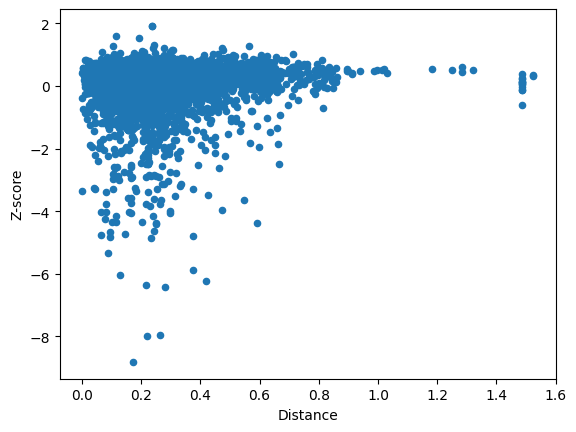

In [187]:
# create a scatter plot of distance vs z_score
shootings_df.plot(kind='scatter', x='distance', y='z_score')

# set the x and y axis labels
plt.xlabel('Distance')
plt.ylabel('Z-score')
plt.title('Histogram of attendance')
# display the plot
plt.show()

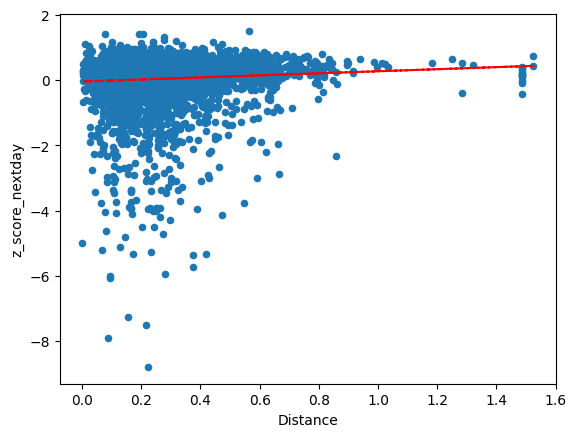

In [194]:
# create a scatter plot of distance vs z_score
shootings_df.plot(kind='scatter', x='distance', y='z_score_nextday')

# calculate the best-fit line using numpy's polyfit function
x = shootings_df['distance']
y = shootings_df['z_score_nextday']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# plot the best-fit line
plt.plot(x,p(x),"r--")

# set the x and y axis labels
plt.xlabel('Distance')
plt.ylabel('z_score_nextday')

# display the plot
plt.show()

In [140]:
school_df=school_df.merge(shootings_df[['nearest_id','occur_date']],left_on=['school','date'],right_on=['nearest_id','occur_date'],how='left')
school_df=school_df.merge(shootings_df[['nearest_id','occur_date_plus1']],left_on=['school','date'],right_on=['nearest_id','occur_date_plus1'],suffixes=(None,'_nextday'),how='left')
school_df['shooting'] = school_df['nearest_id'].notnull()| school_df['nearest_id_nextday'].notnull()
school_df.drop(['nearest_id','occur_date','nearest_id_nextday','occur_date_plus1'],axis=1,inplace=True)

In [141]:
school_df

,school,date,schoolyear,enrolled,present,absent,released,longitude,latitude,month,attendance,mean,std,z_score,shooting
0,01M015,2006-09-05,20062007,252.0,226.0,26.0,0.0,-73.979022,40.721807,9,0.896825,0.862151,0.096213,0.360397,False
1,01M019,2006-09-05,20062007,323.0,290.0,33.0,0.0,-73.983818,40.729636,9,0.897833,0.862151,0.096213,0.370868,False
2,01M020,2006-09-05,20062007,650.0,605.0,45.0,0.0,-73.986648,40.721540,9,0.930769,0.862151,0.096213,0.713197,False
3,01M034,2006-09-05,20062007,376.0,325.0,51.0,0.0,-73.975181,40.726473,9,0.864362,0.862151,0.096213,0.022981,False
4,01M063,2006-09-05,20062007,210.0,193.0,17.0,0.0,-73.986381,40.724117,9,0.919048,0.862151,0.096213,0.591367,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2992411,27Q333,2015-09-08,20152016,560.0,559.0,1.0,0.0,-73.786182,40.593967,117,0.998214,0.795203,0.182440,1.112754,False
2992412,07X527,2016-09-07,20162017,492.0,310.0,182.0,0.0,-73.923829,40.822310,129,0.630081,0.630081,NaN,NaN,False
2992413,17K354,2017-04-17,20162017,221.0,107.0,114.0,0.0,-73.936924,40.672713,136,0.484163,0.484163,NaN,NaN,False
2992414,17K354,2017-04-18,20162017,221.0,153.0,68.0,0.0,-73.936924,40.672713,136,0.692308,0.785015,0.131108,-0.707107,False


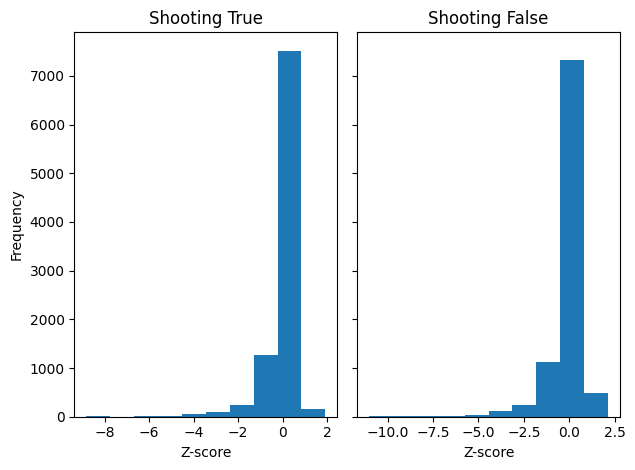

In [142]:
# create two sub-dataframes for when shooting is true and when it is false
shooting_true = school_df[school_df['shooting'] == True]
shooting_false = school_df[school_df['shooting'] == False]
shooting_false = shooting_false.sample(n=shooting_true.shape[0], random_state=42)


# create a figure with two subplots
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# plot the histograms for z_score when shooting is true and false in the respective subplots
axs[0].hist(shooting_true['z_score'])
axs[1].hist(shooting_false['z_score'])

# set the titles for each subplot
axs[0].set_title('Shooting True')
axs[1].set_title('Shooting False')

# set the x and y axis labels
axs[0].set_xlabel('Z-score')
axs[1].set_xlabel('Z-score')
axs[0].set_ylabel('Frequency')

# display the plot
plt.show()


In [143]:
shooting_true.z_score.mean(),shooting_false.z_score.mean()

(0.04587380372335924, -0.004350946685023019)

In [144]:
len(shooting_true),len(shooting_false)

(9388, 9388)

## Bike

In [145]:
bike_df=bike_df[bike_df['latitude']>35] # Remove error

In [146]:
import folium
# Get dataframe of average attendance of each school
average_attendance = bike_df.groupby(['id','latitude','longitude'])['counts'].count()
average_attendance = average_attendance.reset_index()

# Define a color scale based on attendance percentage
color_scale = folium.LinearColormap(
    ['red', 'yellow', 'green'],
    vmin = average_attendance.counts.min(),
    vmax = average_attendance.counts.max()
)

# Create a folium map centered on the United States
map = folium.Map(location=[40.7202, -73.9129], zoom_start=10, tiles="Stamen Toner")

# Add a marker for each school with a color based on attendance percentage
for i, row in average_attendance.iterrows():
    color = color_scale(row['counts']) # get color based on attendance percentage
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=8, # adjust size of circle marker as needed
                        color=color,
                        fill=True,
                        fill_color=color,
                        opacity=0,
                        fill_opacity=0.8).add_to(map)

# Add a color scale legend to the map
color_scale.add_to(map)

# Display the map
map

In [147]:
# Create a copy of the original df
shootings_df=shooting_df.copy()

In [148]:
# Formatting for later merging
bike_df['date_aux'] = pd.to_datetime(bike_df['date']).dt.date
bike_df['date_aux'] = bike_df['date_aux'].astype('datetime64[ns]')

In [149]:
# Formatting and variable creation for later merging
bike_df['date'] = pd.to_datetime(bike_df['date'])

# calculate the 15-minute frame of the week (from 0 to 672) for each row in the bike dataframe and store it in a new column called '15_min_frame_week'
bike_df['15_min_frame_week'] = bike_df['date'].dt.weekday * 96 + bike_df['date'].dt.hour * 4 + bike_df['date'].dt.minute / 15

# group the bike dataframe by 'id' and '15_min_frame_week', and calculate the mean and standard deviation of the 'counts' column for each group
grouped_df = bike_df.groupby(['id', '15_min_frame_week'])['counts'].agg(['mean', 'std']).reset_index()

# merge the mean and standard deviation values back into the bike dataframe using the 'id' and '15_min_frame_week' columns
bike_df = pd.merge(bike_df, grouped_df, on=['id', '15_min_frame_week'])

# calculate the z-score for each row in the bike dataframe using the mean and standard deviation values for that row's 'id' and '15_min_frame_week'
bike_df['z_score_bike'] = (bike_df['counts'] - bike_df['mean']) / bike_df['std']


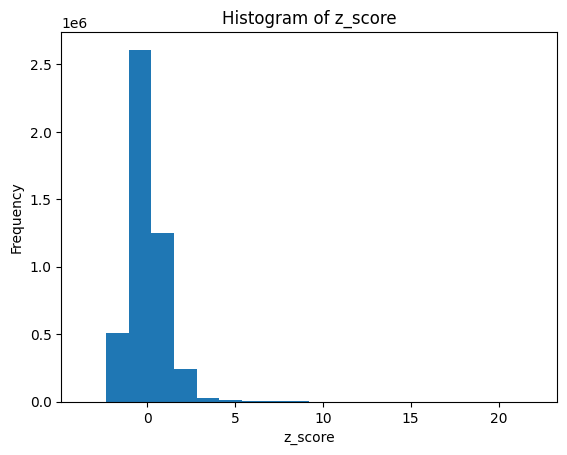

In [150]:
# extract the 'z_score_bike' column from the bike dataframe and store it in a variable called 'z_scores'
z_scores = bike_df['z_score_bike']

# generate a histogram of the z-scores using the matplotlib library
plt.hist(z_scores, bins=20)

# add labels and a title to the histogram
plt.xlabel('z_score')
plt.ylabel('Frequency')
plt.title('Histogram of z_score')

# display the histogram
plt.show()


In [151]:
# Create a copy of the original df
shootings_df=shooting_df.copy()

In [152]:
public_places=['GROCERY/BODEGA', 'BAR/NIGHT CLUB', 'COMMERCIAL BLDG',
       'RESTAURANT/DINER', 'BEAUTY/NAIL SALON', 'FAST FOOD',
       'SOCIAL CLUB/POLICY LOCATI', 'GAS STATION', 'HOSPITAL', 'LIQUOR STORE',
       'SMALL MERCHANT', 'STORE UNCLASSIFIED', 'HOTEL/MOTEL',
       'DRY CLEANER/LAUNDRY', 'SUPERMARKET', 'DRUG STORE', 'CLOTHING BOUTIQUE',
       'JEWELRY STORE', 'TELECOMM. STORE', 'VARIETY STORE', 'SHOE STORE',
       'DEPT STORE', 'FACTORY/WAREHOUSE', 'VIDEO STORE', 'CANDY STORE',
       'CHAIN STORE', 'GYM/FITNESS FACILITY', 'BANK', 'DOCTOR/DENTIST', 'ATM',
       'SCHOOL', 'LOAN COMPANY', 'PHOTO/COPY STORE', 'CHECK CASH',
       'STORAGE FACILITY']
shootings_df['shooting_in_public']=(shootings_df['location_desc'].isin(public_places))

In [153]:
shootings_df=shootings_df[['incident_key','latitude','longitude','occur_date','shooting_in_public','occur_time']]
shootings_df['latitude']=shootings_df['latitude'].astype(float)
shootings_df['longitude']=shootings_df['longitude'].astype(float)

In [154]:
shootings_df['15_min_frame_week'] = round(shootings_df['occur_date'].dt.weekday*96 + shootings_df['occur_time'].dt.hour*4 + shootings_df['occur_time'].dt.minute/15)
shootings_df['15_min_frame_week']=shootings_df['15_min_frame_week'].astype(float)

In [155]:
bike_df_aux=count_location.drop_duplicates(subset='id')
shootings_df.dropna(subset=['latitude','longitude'],inplace=True)
bike_df_aux.dropna(subset=['latitude','longitude'],inplace=True)
# create pairwise distance matrix
distances = cdist(shootings_df[['latitude', 'longitude']], bike_df_aux[['latitude', 'longitude']])

# find index of minimum distance for each row in df1
min_idx = np.argmin(distances, axis=1)
min_dist = np.min(distances, axis=1)

min_dist_km = [geodesic((shootings_df.iloc[i]['latitude'], shootings_df.iloc[i]['longitude']), (bike_df_aux.iloc[min_idx[i]]['latitude'], bike_df_aux.iloc[min_idx[i]]['longitude'])).km for i in range(len(shootings_df))]

# add nearest id to df1
shootings_df['nearest_id'] = bike_df_aux.iloc[min_idx]['id'].values
shootings_df['distance']=min_dist_km
shooting_df_2=shootings_df[shootings_df['distance']<1]

from datetime import timedelta
shooting_df_2['15_min_frame_week_plus1'] = (shooting_df_2['15_min_frame_week'] + 1) % 672

shooting_df_2 = shooting_df_2.merge(bike_df[['id', 'counts', 'z_score_bike','15_min_frame_week','date_aux']], left_on=['nearest_id', '15_min_frame_week','occur_date'], right_on=['id', '15_min_frame_week','date_aux'],how='left',suffixes=(None,'_bike')).drop(['id'], axis=1)
shooting_df_2 = shooting_df_2.merge(bike_df[['id', 'counts', 'z_score_bike','15_min_frame_week','date_aux']], left_on=['nearest_id', '15_min_frame_week_plus1','occur_date'], right_on=['id', '15_min_frame_week','date_aux'],how='left',suffixes=(None,'_next15min')).drop(['id','15_min_frame_week_next15min','15_min_frame_week_plus1','nearest_id','date_aux','date_aux_next15min'], axis=1)
shooting_df_2.drop_duplicates(inplace=True)
shooting_df_2.dropna(subset='counts',inplace=True)
shooting_df_2

/var/folders/fg/p31rnb6d03v9rjynpq9vr7xh0000gn/T/ipykernel_45493/4026371611.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shooting_df_2['15_min_frame_week_plus1'] = (shooting_df_2['15_min_frame_week'] + 1) % 672


,incident_key,latitude,longitude,occur_date,shooting_in_public,occur_time,15_min_frame_week,distance,counts,z_score_bike,counts_next15min,z_score_bike_next15min
2,140340393,40.695368,-73.983242,2014-12-28,False,2023-05-11 19:53:00,656.0,0.534988,7.0,-1.063472,11.0,-0.769435
11,234208836,40.789310,-73.973838,2021-09-28,False,2023-05-11 20:40:00,179.0,0.206029,23.0,0.286588,15.0,-0.401356
13,199247701,40.755442,-73.943422,2019-07-03,False,2023-05-11 00:04:00,192.0,0.552522,33.0,0.647248,18.0,-0.304049
26,222524733,40.754018,-73.948391,2021-01-01,False,2023-05-11 00:16:00,385.0,0.749199,7.0,-1.203381,17.0,-0.222805
36,199900180,40.754164,-73.944653,2019-07-17,False,2023-05-11 16:38:00,259.0,0.498613,72.0,-0.127245,81.0,0.084448
...,...,...,...,...,...,...,...,...,...,...,...,...
1526,250682059,40.814715,-73.924507,2022-09-06,False,2023-05-11 15:50:00,159.0,0.851666,39.0,-0.253863,36.0,-0.502307
1527,250897909,40.737683,-73.852048,2022-09-10,False,2023-05-11 13:59:00,536.0,0.883342,3.0,-0.272012,5.0,0.424075
1529,248390240,40.755434,-73.943421,2022-07-22,False,2023-05-11 01:43:00,391.0,0.551639,13.0,1.151053,16.0,2.203904
1532,238998457,40.752036,-73.942721,2022-01-11,False,2023-05-11 14:45:00,155.0,0.223092,29.0,-0.696354,28.0,-0.771564


## Borough Population

In [156]:
# Create a copy of the original df
shootings_df=shooting_df.copy()

In [157]:
shootings_df=shootings_df[['incident_key','boro']]
shootings_df = pd.merge(shootings_df, bor_population, left_on=['boro'],right_on='borough',how='left')
shootings_df

,incident_key,boro,age_group,borough,_1950,_1950_boro_share_of_nyc_total,_1960,_1960_boro_share_of_nyc_total,_1970,_1970_boro_share_of_nyc_total,...,_2000,_2000_boro_share_of_nyc_total,_2010,_2010_boro_share_of_nyc_total,_2020,_2020_boro_share_of_nyc_total,_2030,_2030_boro_share_of_nyc_total,_2040,_2040_boro_share_of_nyc_total
0,228798151,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,137471050,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,147998800,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,146837977,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,58921844,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27307,245029823,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27308,239583450,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27309,246825728,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27310,246876579,BRONX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Construction

In [158]:
# Data transforming
construction_df['total_est__fee']=construction_df['total_est__fee'].str.replace('$', '').astype(float)

/var/folders/fg/p31rnb6d03v9rjynpq9vr7xh0000gn/T/ipykernel_45493/2134467426.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  construction_df['total_est__fee']=construction_df['total_est__fee'].str.replace('$', '').astype(float)


In [159]:
#Loading the shooting dataset
start_time = time.time()

results = client.get_all("833y-fsy8")

print(f"Shooting data frame loaded in {time.time() - start_time:.2f} seconds.")


# Convert to pandas DataFrame
shootings_df = pd.DataFrame.from_records(results)
shootings_df['occur_date']=pd.to_datetime(shootings_df['occur_date'])
shootings_df['occur_time']=pd.to_datetime(shootings_df['occur_time'])


print(shootings_df.columns, len(shootings_df))
shootings_df.head()

Shooting data frame loaded in 0.00 seconds.
Index(['incident_key', 'occur_date', 'occur_time', 'boro', 'precinct',
       'jurisdiction_code', 'statistical_murder_flag', 'vic_age_group',
       'vic_sex', 'vic_race', 'x_coord_cd', 'y_coord_cd', 'latitude',
       'longitude', 'geocoded_column', ':@computed_region_yeji_bk3q',
       ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih',
       ':@computed_region_efsh_h5xi', ':@computed_region_f5dn_yrer',
       'perp_age_group', 'perp_sex', 'perp_race', 'location_desc',
       'loc_of_occur_desc', 'loc_classfctn_desc'],
      dtype='object') 27312


,incident_key,occur_date,occur_time,boro,precinct,jurisdiction_code,statistical_murder_flag,vic_age_group,vic_sex,vic_race,...,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,perp_age_group,perp_sex,perp_race,location_desc,loc_of_occur_desc,loc_classfctn_desc
0,228798151,2021-05-27,2023-05-11 21:30:00,QUEENS,105,0,False,18-24,M,BLACK,...,47,63,24018,63,NaN,NaN,NaN,NaN,NaN,NaN
1,137471050,2014-06-27,2023-05-11 17:40:00,BRONX,40,0,False,18-24,M,BLACK,...,35,23,10932,49,NaN,NaN,NaN,NaN,NaN,NaN
2,147998800,2015-11-21,2023-05-11 03:56:00,QUEENS,108,0,True,25-44,M,WHITE,...,33,66,14787,53,NaN,NaN,NaN,NaN,NaN,NaN
3,146837977,2015-10-09,2023-05-11 18:30:00,BRONX,44,0,False,<18,M,WHITE HISPANIC,...,42,27,10930,50,NaN,NaN,NaN,NaN,NaN,NaN
4,58921844,2009-02-19,2023-05-11 22:58:00,BRONX,47,0,True,45-64,M,BLACK,...,2,30,11275,29,25-44,M,BLACK,NaN,NaN,NaN


In [160]:
# Taking latitude and longitude as float for merging
shootings_df.latitude=shootings_df.latitude.astype(float)
shootings_df.longitude=shootings_df.longitude.astype(float)
construction_df.gis_latitude=construction_df.gis_latitude.astype(float)
construction_df.gis_longitude=construction_df.gis_longitude.astype(float)

In [161]:
# Define step sizes for latitude and longitude
stepsize_lat = 0.009 # Roughly, 1 kilometer
stepsize_lon = 0.012 # Roughly, 1 kilometer

# Calculate minimum and maximum values for latitude and longitude across both dataframes
latmin = min(shootings_df.latitude.min(), construction_df.gis_latitude.min())
lonmin = min(shootings_df.longitude.min(), construction_df.gis_longitude.min())
lonmax = max(shootings_df.longitude.max(), construction_df.gis_longitude.max())
latmax = max(shootings_df.latitude.max(), construction_df.gis_latitude.max())

# Calculate number of rows and columns in the grid based on the step sizes and range of latitude and longitude
num_rows = int((latmax - latmin) / stepsize_lat) + 1
num_cols = int((lonmax - lonmin) / stepsize_lon) + 1

# Define a function to get the grid number for a given latitude and longitude
def get_grid_number(latitude, longitude, stepsize_lat=stepsize_lat, stepsize_lon=stepsize_lon, latmin=latmin, lonmin=lonmin):
    # Calculate row and column numbers based on the latitude and longitude values
    row = int((latitude - latmin) / stepsize_lat)
    col = int((longitude - lonmin) / stepsize_lon)
    # Calculate the grid number based on the row and column numbers
    grid_number = row * num_cols + col
    return grid_number


In [ ]:
# Drop rows with missing latitude and longitude values in dfs
shootings_df.dropna(subset=['latitude', 'longitude'], inplace=True)
construction_df.dropna(subset=['gis_latitude', 'gis_longitude'], inplace=True)

# Map each row in shootings_df and construction_df to a grid cell number using the get_grid_number function
shootings_df['grid_number'] = shootings_df.apply(lambda row: get_grid_number(row['latitude'], row['longitude'], stepsize_lat, stepsize_lon, latmin, lonmin), axis=1)
construction_df['grid_number'] = construction_df.apply(lambda row: get_grid_number(row['gis_latitude'], row['gis_longitude'], stepsize_lat, stepsize_lon, latmin, lonmin), axis=1)


In [ ]:
# Remove columns and group by grid_number to get count of incidents in each grid
shootings_df_ = shootings_df[['incident_key', 'grid_number']]
shootings_df_ = shootings_df_.groupby('grid_number').count()['incident_key'].reset_index()

# Merge with original dataframe to add 'boro' column back
shootings_df = shootings_df_.merge(shootings_df[['boro', 'grid_number']], on='grid_number', how='left')

# Rename 'incident_key' column to 'Incident_count'
shootings_df.rename(columns={'incident_key': 'Incident_count'}, inplace=True)

# Group construction_df by grid_number and get sum of 'total_est__fee'
construction_df_total = construction_df[['total_est__fee', 'borough', 'grid_number']].groupby('grid_number').sum()

# Merge shootings_df with construction_df_total on 'grid_number'
shootings_df = pd.merge(shootings_df, construction_df_total, on='grid_number', how='left')


/var/folders/fg/p31rnb6d03v9rjynpq9vr7xh0000gn/T/ipykernel_45493/2321568304.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  construction_df_total = construction_df[['total_est__fee', 'borough', 'grid_number']].groupby('grid_number').sum()


<Axes: xlabel='Incident_count', ylabel='total_est__fee'>

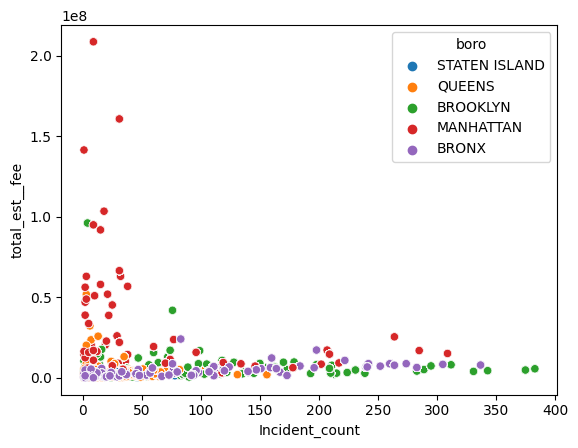

In [ ]:
sns.scatterplot(data=shootings_df, x='Incident_count', y='total_est__fee',hue='boro')

shooting_dfWe can see that the grid with the most investments are in the places with the least shooting count! Furthermore, we can see that those grid corresponds to either Brooklyn or Manhattan. In adittion, Bronx is usually at the bottom

In addition, we can see that for some places located in Manhattan and Brooklyn  with the most number of incidents, the total investment is relatively low. 


However, the reality is more complex than that, and it is very likely that the shootings incidents are not the only factor affecting the total investments. 
Are the shootings a cause of lower investment and lower social development indices? or is it the other way around? Being the shooting a consequence of that and the '